In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import PIL
import torch
from torch import nn
import numpy as np
import os 
import random
import time
from pathlib import Path

In [56]:
DATA_PATH = Path(r'c:\Users\csunga\Documents\code\comp-n-net') / 'data' / 'dl-data' 
DATA_PATH_X = DATA_PATH / 'input' 
DATA_PATH_Y = DATA_PATH / 'output'
BATCH_SIZE = 1
IMG_SIZE = (512)
VALID_PER = 0.5
SEED = 21

In [57]:
def data_dirs_maker(data_type: str, *args: str) -> list:           # curv / img
    data_dirs = []
    for geom_type_name in args:
        data_dirs.append(DATA_PATH_X / geom_type_name / data_type)
    return data_dirs

In [58]:
from array import array
import os
from torchvision.io import read_image
import numpy as np

class CustomImageDataset(Dataset):
    def __init__(
            self, 
            input_dirs: list[Path], 
            label_dir: Path, 
            transform=None,
            label_type='img'
            ) -> None:
        self.label_dir = label_dir
        self.input_dirs = input_dirs
        self.transform = transform
        self.label_type = label_type

    def __len__(self):
        length = 0
        for geom_types in self.input_dirs:
            length += len(list(geom_types.glob('*')))
        return length

    def dir_checker(self, idx) -> tuple:
        length = 0
        for geom_types in self.input_dirs:
            act_length = length + len(list(geom_types.glob('*')))
            if act_length >= idx + 1:
                return (geom_types, idx - length)
            length = act_length
        raise IndexError(f"not supossed to be here: {idx, length}")

    def npz_read_image(self, data_path: Path) -> torch.Tensor:
        numpy_array = np.load(data_path)['arr_0']
        torch_array = torch.from_numpy(numpy_array)
        return torch_array

    def pkl_read_image(self, data_path: Path) -> torch.Tensor:
        raise NotImplementedError("Function should be implemented")

    def __getitem__(self, idx):
        work_dir_path, new_id = self.dir_checker(idx)
        input_path = list(work_dir_path.glob('*'))[new_id]
        label_path = self.label_dir \
            / work_dir_path.parents[0].name \
            / self.label_type \
            / input_path.with_suffix('.png').name

        image = self.npz_read_image(input_path)
        label = read_image(str(label_path))[0]
        if self.transform:
            image, label = self.transform(image, label)
        return image, label

In [59]:
input_dirs = data_dirs_maker('curv', 'elliptical', 'parabolical')
print(input_dirs)

[WindowsPath('c:/Users/csunga/Documents/code/comp-n-net/data/dl-data/input/elliptical/curv'), WindowsPath('c:/Users/csunga/Documents/code/comp-n-net/data/dl-data/input/parabolical/curv')]


In [60]:
dataset = CustomImageDataset(input_dirs, DATA_PATH_Y)

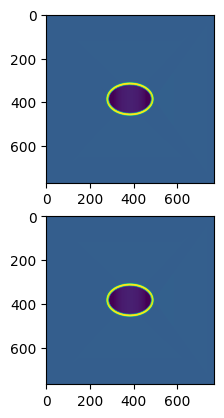

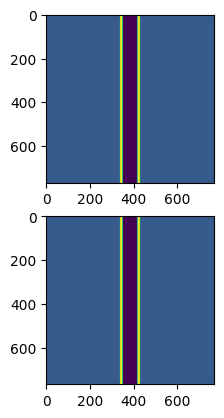

In [61]:
for i in range(len(dataset)):
    data, label = dataset[i]
    plt.subplot(211)
    plt.imshow(data)
    plt.subplot(212)
    plt.imshow(label)

    plt.show()

In [62]:
print(iter(dataset))

In [63]:
for data, label in iter(dataset):
    print(type(data))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [64]:
class MyTransform:
    def __init__(self, img_size, aug_mode=True):
        self.img_size = (img_size)
        self.aug_mode = aug_mode

    def __call__(self, img, lbl):
        rot_bool = True if random.random() > 0.5 else False
        aug_bool = (rot_bool)
        img = img[None, :]
        lbl = lbl[None, :]
        img = self.transform(img, aug_bool)
        lbl = self.transform(lbl, aug_bool)
        return img, lbl

    def transform(self, x, aug_bool):
        resized_img = transforms.Resize(size=self.img_size)(x)
        pil_img =transforms.ToPILImage()(resized_img)
        if self.aug_mode:
            return self.augmentation(pil_img, aug_bool)
        else:
            return transforms.ToTensor()(pil_img)


    def augmentation(self, img, aug_bool):
        rot_bool = aug_bool
        aug_img = img.copy()
        if rot_bool:
            aug_img = transforms.functional.rotate(aug_img, 90)           
        return transforms.ToTensor()(aug_img)

In [65]:
dset = CustomImageDataset(input_dirs, DATA_PATH_Y, transform=MyTransform(IMG_SIZE))

In [66]:
print(len(dset))

2


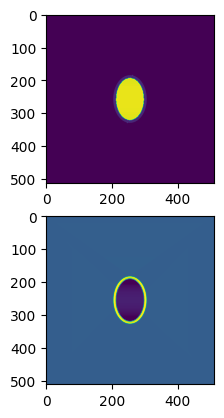

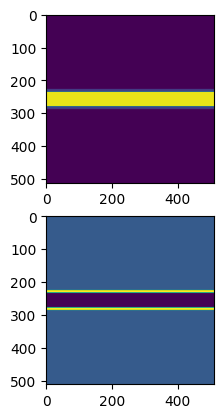

In [67]:
for i in range(len(dset)):
    data, label = dset[i]
    data = data[0]
    label = label[0]    
    plt.subplot(211)
    plt.imshow(data)
    plt.subplot(212)
    plt.imshow(label)

    plt.show()    

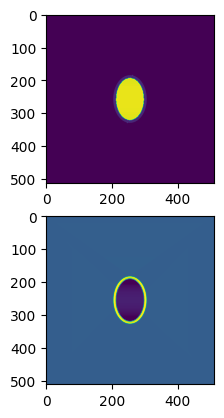

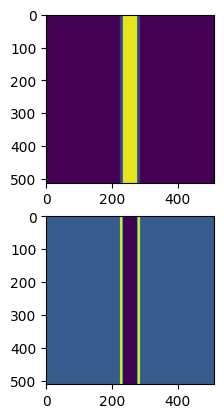

In [68]:
for count, (data, label) in enumerate(iter(dset)):
    data = data[0]
    label = label[0]

    plt.subplot(211)
    plt.imshow(data)
    plt.subplot(212)
    plt.imshow(label)

    plt.show()

In [69]:
def split_calculator(dataset, valid_per):
    number_of_file = len(dataset)
    split_length = [valid_per*number_of_file, (1-valid_per)*number_of_file]
    return [round(split_length[0]), round(split_length[1])]

In [70]:
split_length = split_calculator(dset, VALID_PER)
training_dset, validation_dset = torch.utils.data.random_split(dset, split_length, generator=torch.Generator().manual_seed(SEED))

In [84]:
class DataLoaderGenerator:
    def __call__(
            self, 
            ImageDataset: CustomImageDataset,
            transform_class: MyTransform,
            input_dirs: list[Path],
            DATA_PATH_Y: Path,
            IMG_SIZE: tuple,
            VALID_PER: float,
            SEED: int,
            # ) -> tuple(torch.utils.data.DataLoader):
            ):
        dset = ImageDataset(input_dirs, DATA_PATH_Y, transform=transform_class(IMG_SIZE))
        split_length = self.split_calculator(dset, VALID_PER)
        training_dset, validation_dset = torch.utils.data.random_split(
            dset, 
            split_length, 
            generator=torch.Generator().manual_seed(SEED)
            )
        training_dls = torch.utils.data.DataLoader(training_dset, batch_size=BATCH_SIZE, shuffle=True)
        validation_dls = torch.utils.data.DataLoader(validation_dset, batch_size=BATCH_SIZE)            
        return (training_dls, validation_dls)
        
    
    def split_calculator(self, dataset: torch.utils.data.Dataset, valid_per: float) -> list[float]:
        number_of_file = len(dataset)
        split_length = [valid_per*number_of_file, (1-valid_per)*number_of_file]
        return [round(split_length[0]), round(split_length[1])]


In [79]:
print(len(training_dset))
print(len(validation_dset))

1
1


In [72]:
training_dls = torch.utils.data.DataLoader(training_dset, batch_size=BATCH_SIZE, shuffle=True)
validation_dls = torch.utils.data.DataLoader(validation_dset, batch_size=BATCH_SIZE)

In [85]:
dls_gen = DataLoaderGenerator()
training_dls, validation_dls = dls_gen(
    CustomImageDataset,
    MyTransform,
    input_dirs,
    DATA_PATH_Y,
    IMG_SIZE,
    VALID_PER,
    SEED,
)

In [86]:
def status_logger(dls):
    for X, y in dls:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

In [87]:
status_logger(training_dls)
status_logger(validation_dls)

Shape of X [N, C, H, W]: torch.Size([1, 1, 512, 512])
Shape of y: torch.Size([1, 1, 512, 512]) torch.float32
Shape of X [N, C, H, W]: torch.Size([1, 1, 512, 512])
Shape of y: torch.Size([1, 1, 512, 512]) torch.float32
